In [1]:
import os
os.environ["ESMFMKFILE"] = "/users_home/cmcc/ls21622/.conda/envs/DEVELOP/lib/esmf.mk"
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy
import numpy as np
import pandas as pd
import xarray as xr
import scipy
from scipy import special
from scipy.stats import norm
from scipy.stats import ks_2samp as ks_2samp
import sys 
import xesmf as xe 
import cartopy.feature as cfeature
import cftime
from netCDF4 import Dataset
from netCDF4 import num2date
from statsmodels.stats.multitest import multipletests

In [2]:
#W = int(sys.argv[1])
#D = str(sys.argv[2])

W = 0
D = 'ccs'

print(f'PROCESSING {W}')
print(f'PROCESSING {D}')

do_plot=D

root_dir = '/data/cmcc/ls21622/gcm_driven_experiment_from_nird/'
fig_dir = '/work3/lorenzosangelantoni/scratch75/gcm_driven_experiment_from_nird/scripts/python_2/plotter/dsl/figures' 

execute_array_his   =  (["ds_his.DSL_mean", "ds_his.DSL_max", "ds_his.DSL_number"])
execute_array_rcp85 =  (["ds_rcp85.DSL_mean", "ds_rcp85.DSL_max", "ds_rcp85.DSL_number"])

boundaries = np.array([0,17.5,40,51]) ; min_lon,max_lon,min_lat,max_lat = boundaries
boundaries2 = np.array([-1,18.5,39,52]) ; lon_min,lon_max,lat_min,lat_max = boundaries2
boundaries = np.array([1,16.9,40,50]) ; min_lon,max_lon,min_lat,max_lat = boundaries
boundaries = np.array([1,16.9,40.5,50]) ; min_lon,max_lon,min_lat,max_lat = boundaries



models_ranked_to_plot = [ 'BCCR-AUTH','FZJ-IDL','BTU','CMCC','KIT','ETHZ','HCLIM','KNMI','CNRM','ICTP','UKMO']

var = ['DSL_mean', 'DSL_max', 'DSL_number']
var = var[W]
var_to_tit = ["mean DSL","max DSL", "DSL number"]
var_to_tit = var_to_tit[W]
to_save= ["DSL_mean", "DSL_max","DSL_number"]

clabs=["Days","Days","N."]

if do_plot == 'his' :
    cmin=[ 2,  3 , 1 ]
    cmax=[ 24, 50, 15 ]
    cint=[ 12 ,48,  1 ]
    cmin_bias=[-6, -6,-3, -5, -3 ]
    cmax_bias=[ 6,  6, 3,  5,  3 ]
    cint_bias=[ 13,13, 7, 11,  7 ]
    levels_bias = np.linspace(cmin_bias[W],cmax_bias[W],cint_bias[W])
    
else :
    cmin=[ -18, -28, -10 ]
    cmax=[  18,  28,  10 ]
    cint=[  19,   15, 11 ]
    #cmin=[ -18, -28, -10 ]
    #cmax=[  18,  28,  10 ]
    #cint=[  2,   15, 11 ]
    
cmin_spread=[ 2,  2,  0  ]
cmax_spread=[ 15, 15, 10 ]
cint_spread=[ 14,  14, 11 ]

levels = np.linspace(cmin[W],cmax[W],cint[W])
#levels = np.arange(cmin[W],cmax[W],cint[W])

#levels_std  = np.arange(cmin_spread[W],cmax_spread[W],cint_spread[W])
levels_std  = np.linspace(cmin_spread[W],cmax_spread[W],cint_spread[W])

colormap_his = ['turbo', 'turbo', 'turbo']
colormap_ccs = 'Spectral_r'
colormap_bias = 'coolwarm'
colormap_std = 'viridis'

PROCESSING 0
PROCESSING ccs


### RCMs

In [3]:
models_ranked_to_plot = [ 'BCCR-AUTH','FZJ-IDL','BTU','CMCC','KIT','ETHZ','HCLIM','KNMI','CNRM','ICTP','UKMO']
models = [ 'BCCR-AUTH','BTU','CMCC','CNRM','ETHZ','FZJ-IDL','HCLIM','ICTP','KIT','KNMI','UKMO']

dir_home_his     = f'{root_dir}/scripts/python_2/dsl/OUTPUTS/historical/nonCP'
dir_home_rcp85   = f'{root_dir}/scripts/python_2/dsl/OUTPUTS/rcp85/nonCP'

# Load datasets
ds_his = []
ds_his = xr.open_mfdataset(f'{dir_home_his}/*.nc',combine='nested',concat_dim='model')
ds_his.load()
ds_his = ds_his.sel(model=models_ranked_to_plot)
ds_his['lat'] = ds_his.lat.mean(dim='model')
ds_his['lon'] = ds_his.lon.mean(dim='model')
lon_in = ds_his['lon']
lat_in = ds_his['lat']

ds_rcp85 = []
ds_rcp85 = xr.open_mfdataset(f'{dir_home_rcp85}/*.nc',combine='nested',concat_dim='model')
ds_rcp85.load()
ds_rcp85 = ds_rcp85.sel(model=models_ranked_to_plot)
ds_rcp85['lat'] = ds_rcp85.lat.mean(dim='model')
ds_rcp85['lon'] = ds_rcp85.lon.mean(dim='model')

if do_plot == 'his' :
    V_rcm = eval(execute_array_his[W]).mean(dim='time').quantile(.5, dim='model').assign_coords(ENS='RCMs')
    V_rcm = V_rcm.assign_coords(lon=ds_his.lon, lat=ds_his.lat)
    V_rcm_std = eval(execute_array_his[W]).mean(dim='time').std(dim='model').assign_coords(ENS='RCMs')
    
if do_plot == 'ccs' : 
    V_rcm = eval(execute_array_rcp85[W]).mean(dim='time').quantile(.5, dim='model') - eval(execute_array_his[W]).mean(dim='time').quantile(.5, dim='model').assign_coords(ENS='RCMs')
    V_rcm = V_rcm.assign_coords(lon=ds_his.lon, lat=ds_his.lat)
    V_rcm_std = np.std(eval(execute_array_rcp85[W]).mean(dim='time') - eval(execute_array_his[W]).mean(dim='time').assign_coords(ENS='RCMs'),axis=0)
    V_rcm_std = V_rcm_std.assign_coords(lon=ds_his.lon, lat=ds_his.lat)
    
    dummy_p_mat = np.empty([len(models),ds_his.DSL_mean.shape[2],ds_his.DSL_mean.shape[3]])
    dummy_p_mat_fdr = np.empty([len(models),ds_his.DSL_mean.shape[2],ds_his.DSL_mean.shape[3]])
    trend_signs = np.empty([len(models), ds_his.DSL_mean.shape[2], ds_his.DSL_mean.shape[3]])
    

    # Iterate through each model to compute the t-test, p-values, and signs
    for i in range(0, len(models)):
        V = eval(execute_array_rcp85[W])[i, :, :, :].mean(dim=('time')) - eval(execute_array_his[W])[i, :, :, :].mean(dim=('time'))
        H = eval(execute_array_his[W])[i, :, :, :]
        F = eval(execute_array_rcp85[W])[i, :, :, :]
        
        # Compute t-test for each model
        s, p = scipy.stats.ttest_ind(H, F, axis=0, equal_var=False, nan_policy='omit')
        
        dummy_p_mat[i, :, :] = p
        trend_signs[i, :, :] = np.sign(s)  # Store the sign of the trend based on t-statistic `s`
        
        # FDR correction
        p_values_flat = p.flatten()
        non_nan_mask = ~np.isnan(p_values_flat)
        p_values_filtered = p_values_flat[non_nan_mask]
        
        if len(p_values_filtered) == 0:
            continue  # Skip if no valid p-values
        
        _, corrected_p_values, _, _ = multipletests(p_values_filtered, alpha=0.05, method='fdr_bh')
        
        corrected_p_values_mat = np.full(p.shape, np.nan)
        np.put(corrected_p_values_mat, np.where(non_nan_mask)[0], corrected_p_values)
        dummy_p_mat_fdr[i, :, :] = corrected_p_values_mat


    # Step 1: Test for significant changes using FDR-corrected p-values
    # Convert p-values to binary significance mask (1 for significant, NaN for non-significant)
    dummy_p_mat[dummy_p_mat > 0.05] = np.NaN
    dummy_p_mat[dummy_p_mat <= 0.05] = 1
    dummy_p_mat_fdr[dummy_p_mat_fdr > 0.05] = np.NaN
    dummy_p_mat_fdr[dummy_p_mat_fdr <= 0.05] = 1
    
    
    # Step 1: Find how many models show significant trend for each grid point
    significant_models_count = np.nansum(dummy_p_mat, axis=0)  # Sum along the model dimension (axis 0)
    significant_mask = (np.nansum(~np.isnan(dummy_p_mat),axis=0)/len(models))<.5  # Binary mask for significant trends
    # Apply the first mask: Where `significant_mask` is true, keep `significant_models_count`, otherwise set to 9999
    to_stipple_mask = np.where(np.isnan(V_rcm), np.nan, significant_mask)
    to_stipple_mask_rcm = np.where(to_stipple_mask==0, np.nan, to_stipple_mask)
    
    # Step 2: Find the sign of significant trends from each model
    trend_sign = np.where(np.isnan(dummy_p_mat), np.nan, trend_signs)
    # Derive trend sign agreement, wherever
    trend_sign_agreement = np.nansum(trend_sign,axis=0)
    # Derive trend sign agreement only over 50% of model shows significant trend
    trend_sign_agreement_masked = np.where(significant_mask==0, trend_sign_agreement, np.nan)
    
    # Derive the percentage of the model agreement over the sign where significant trends result 
    trend_sign_agreement_masked_percentage = np.abs(trend_sign_agreement_masked)/significant_models_count
    # Mask where significant trend sign agreement is lower than .80
    to_hatch_mask_rcm = np.where(trend_sign_agreement_masked_percentage<.66, 1, np.nan)
    
    
    #fdr-adjusted p-value
    
    # Step 1: Find how many models show significant trend for each grid point
    significant_models_count = np.nansum(dummy_p_mat_fdr, axis=0)  # Sum along the model dimension (axis 0)
    significant_mask = (np.nansum(~np.isnan(dummy_p_mat_fdr),axis=0)/len(models))<.5  # Binary mask for significant trends
    # Apply the first mask: Where `significant_mask` is true, keep `significant_models_count`, otherwise set to 9999
    to_stipple_mask = np.where(np.isnan(V_rcm), np.nan, significant_mask)
    to_stipple_mask_fdr_rcm = np.where(to_stipple_mask==0, np.nan, to_stipple_mask)
    
    # Step 2: Find the sign of significant trends from each model
    trend_sign = np.where(np.isnan(dummy_p_mat_fdr), np.nan, trend_signs)
    # Derive trend sign agreement, wherever
    trend_sign_agreement = np.nansum(trend_sign,axis=0)
    # Derive trend sign agreement only over 50% of model shows significant trend
    trend_sign_agreement_masked = np.where(significant_mask==0, trend_sign_agreement, np.nan)
    
    # Derive the percentage of the model agreement over the sign where significant trends result 
    trend_sign_agreement_masked_percentage = np.abs(trend_sign_agreement_masked)/significant_models_count
    # Mask where significant trend sign agreement is lower than .80
    to_hatch_mask_fdr_rcm = np.where(trend_sign_agreement_masked_percentage<.66, 1, np.nan)


/users_home/cmcc/ls21622/.conda/envs/DEVELOP/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/users_home/cmcc/ls21622/.conda/envs/DEVELOP/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/users_home/cmcc/ls21622/.conda/envs/DEVELOP/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


### Interpolate RCMs in reference dataset grids

In [11]:
if D=='his' : 
    dir_obs=' /data/cmcc/ls21622/gcm_driven_experiment_from_nird/OBSERVATIONS'
    euro4m=f'{dir_obs}/EURO4M/DSL/EURO4M-APGD-1996-2005_JJA.nc'
    gripho=f'{dir_obs}/ITALY/DSL/gripho-v1_day_TSmin30pct_2001-2010_JJA.nc'
    regnie=f'{dir_obs}/REGNIE/DSL/regnie_19960601_20050831.nc'
    safran=f'{dir_obs}/SAFRAN/ForcPRCP/DSL/ForcPRCP_france_SAFRAN_8Km_1hour_1995080100_2006073123_V1_01_day.nc'
    
    dataset   = Dataset(f'{euro4m}', mode='r')
    lon_out_eu = dataset.variables['longitude'][:]
    lat_out_eu = dataset.variables['latitude'][:]
    dsl_euro4m=dataset.variables['dsl_mean'][:]
    grid_in   = {"lon": lon_in, "lat": lat_in}
    grid_out  = {"lon": lon_out_eu, "lat": lat_out_eu}
    regridder = xe.Regridder(grid_in, grid_out, "bilinear")
    V_rcm_regr_euro4m = regridder(V_rcm)

    dataset   = Dataset(f'{gripho}', mode='r')
    lon_out_gr = dataset.variables['longitude'][:]
    lat_out_gr = dataset.variables['latitude'][:]
    dsl_gripho=dataset.variables['dsl_mean'][:]
    grid_in   = {"lon": lon_in, "lat": lat_in}
    grid_out  = {"lon": lon_out_gr, "lat": lat_out_gr}
    regridder = xe.Regridder(grid_in, grid_out, "bilinear")
    V_rcm_regr_gripho = regridder(V_rcm)

    dataset   = Dataset(f'{safran}', mode='r')
    lon_out_sf = dataset.variables['longitude'][:]
    lat_out_sf = dataset.variables['latitude'][:]
    dsl_safran=dataset.variables['dsl_mean'][:]
    grid_in   = {"lon": lon_in, "lat": lat_in}
    grid_out  = {"lon": lon_out_sf, "lat": lat_out_sf}
    regridder = xe.Regridder(grid_in, grid_out, "bilinear")
    V_rcm_regr_safran = regridder(V_rcm)

    dataset   = Dataset(f'{regnie}', mode='r')
    lon_out_rg = dataset.variables['longitude'][:]
    lat_out_rg = dataset.variables['latitude'][:]
    dsl_regnie=dataset.variables['dsl_mean'][:]
    grid_in   = {"lon": lon_in, "lat": lat_in}
    grid_out  = {"lon": lon_out_rg, "lat": lat_out_rg}
    regridder = xe.Regridder(grid_in, grid_out, "bilinear")
    V_rcm_regr_regnie = regridder(V_rcm)

### CPRCMs

In [4]:
res='CPRCM'

models_ranked_to_plot = [ 'BCCR-AUTH','FZJ-IDL','BTU','CMCC','KIT','ETHZ','HCLIM','KNMI','CNRM','ICTP','UKMO','JLU']
models = [ 'BCCR-AUTH','BTU','CMCC','CNRM','ETHZ','FZJ-IDL','HCLIM','ICTP','KIT','KNMI','UKMO','JLU']

dir_home_his     = f'{root_dir}/scripts/python_2/dsl/OUTPUTS/historical/CP'
dir_home_rcp85   = f'{root_dir}/scripts/python_2/dsl/OUTPUTS/rcp85/CP'

# Load datasets
ds_his = []
ds_his = xr.open_mfdataset(f'{dir_home_his}/*.nc',combine='nested',concat_dim='model')
ds_his.load()
ds_his = ds_his.sel(model=models_ranked_to_plot)
ds_his['lat'] = ds_his.lat.mean(dim='model')
ds_his['lon'] = ds_his.lon.mean(dim='model')
lon_in = ds_his['lon']
lat_in = ds_his['lat']

ds_rcp85 = []
ds_rcp85 = xr.open_mfdataset(f'{dir_home_rcp85}/*.nc',combine='nested',concat_dim='model')
ds_rcp85.load()
ds_rcp85 = ds_rcp85.sel(model=models_ranked_to_plot)
ds_rcp85['lat'] = ds_rcp85.lat.mean(dim='model')
ds_rcp85['lon'] = ds_rcp85.lon.mean(dim='model')

if do_plot == 'his' :
    V_cprcm = eval(execute_array_his[W]).mean(dim='time').quantile(.5, dim='model').assign_coords(ENS='RCMs')
    V_cprcm = V_cprcm.assign_coords(lon=ds_his.lon, lat=ds_his.lat)
    V_cprcm_std = eval(execute_array_his[W]).mean(dim='time').std(dim='model').assign_coords(ENS='CPRCMs')
    
if do_plot == 'ccs' : 
    V_cprcm = eval(execute_array_rcp85[W]).mean(dim='time').quantile(.5, dim='model') - eval(execute_array_his[W]).mean(dim='time').quantile(.5, dim='model').assign_coords(ENS='RCMs')
    V_cprcm = V_cprcm.assign_coords(lon=ds_his.lon, lat=ds_his.lat)
    V_cprcm_std = np.std(eval(execute_array_rcp85[W]).mean(dim='time') - eval(execute_array_his[W]).mean(dim='time').assign_coords(ENS='CPRCMs'),axis=0)
    V_cprcm_std = V_cprcm_std.assign_coords(lon=ds_his.lon, lat=ds_his.lat)

    dummy_p_mat = np.empty([len(models),ds_his.DSL_mean.shape[2],ds_his.DSL_mean.shape[3]])
    dummy_p_mat_fdr = np.empty([len(models),ds_his.DSL_mean.shape[2],ds_his.DSL_mean.shape[3]])
    trend_signs = np.empty([len(models), ds_his.DSL_mean.shape[2], ds_his.DSL_mean.shape[3]])

    for i in range(0,len(models)) :
        
        V = eval(execute_array_rcp85[W])[i,:,:,:].mean(dim=('time')) - eval(execute_array_his[W])[i,:,:,:].mean(dim=('time'))

        H = eval(execute_array_his[W])[i,:,:,:];   
        F = eval(execute_array_rcp85[W])[i,:,:,:]; 
            
        # Compute ttest for each model
        s,p=scipy.stats.ttest_ind(H ,F, axis=0, equal_var=False,nan_policy='omit')
        
        dummy_p_mat[i,:,:] = p 
        trend_signs[i, :, :] = np.sign(s)  # Store the sign of the trend based on t-statistic `s`
        
        # FDR     
        # Flatten the p-values and retain a mask of non-NaN values
        p_values_flat = p.flatten()
        non_nan_mask = ~np.isnan(p_values_flat)
            
        # Filter non-NaN p-values
        p_values_filtered = p_values_flat[non_nan_mask]
        
        # If no valid p-values are present, skip to the next iteration
        if len(p_values_filtered) == 0:
            print("No valid p-values for this iteration, skipping.")
                
        # Apply FDR correction
        _, corrected_p_values, _, _ = multipletests(p_values_filtered, alpha=0.05, method='fdr_bh')
        
        # Create an array filled with NaNs (same shape as `p`)
        corrected_p_values_mat = np.full(p.shape, np.nan)
        
        # Instead of using flatten, index directly into the flattened view
        np.put(corrected_p_values_mat, np.where(non_nan_mask)[0], corrected_p_values)
        
        # Store the corrected p-values into dummy_p_mat_fdr
        dummy_p_mat_fdr[i, :, :] = corrected_p_values_mat
    

    # Step 1: Test for significant changes using FDR-corrected p-values
    # Convert p-values to binary significance mask (1 for significant, NaN for non-significant)
    dummy_p_mat[dummy_p_mat > 0.05] = np.NaN
    dummy_p_mat[dummy_p_mat <= 0.05] = 1
    dummy_p_mat_fdr[dummy_p_mat_fdr > 0.05] = np.NaN
    dummy_p_mat_fdr[dummy_p_mat_fdr <= 0.05] = 1
    
    
    # Step 1: Find how many models show significant trend for each grid point
    significant_models_count = np.nansum(dummy_p_mat, axis=0)  # Sum along the model dimension (axis 0)
    significant_mask = (np.nansum(~np.isnan(dummy_p_mat),axis=0)/len(models))<.5  # Binary mask for significant trends
    # Apply the first mask: Where `significant_mask` is true, keep `significant_models_count`, otherwise set to 9999
    to_stipple_mask = np.where(np.isnan(V_cprcm), np.nan, significant_mask)
    to_stipple_mask_cprcm = np.where(to_stipple_mask==0, np.nan, to_stipple_mask)
    
    # Step 2: Find the sign of significant trends from each model
    trend_sign = np.where(np.isnan(dummy_p_mat), np.nan, trend_signs)
    # Derive trend sign agreement, wherever
    trend_sign_agreement = np.nansum(trend_sign,axis=0)
    # Derive trend sign agreement only over 50% of model shows significant trend
    trend_sign_agreement_masked = np.where(significant_mask==0, trend_sign_agreement, np.nan)
    
    # Derive the percentage of the model agreement over the sign where significant trends result 
    trend_sign_agreement_masked_percentage = np.abs(trend_sign_agreement_masked)/significant_models_count
    # Mask where significant trend sign agreement is lower than .80
    to_hatch_mask_cprcm = np.where(trend_sign_agreement_masked_percentage<.66, 1, np.nan)
    
    
    #fdr-adjusted p-value
    
    # Step 1: Find how many models show significant trend for each grid point
    significant_models_count = np.nansum(dummy_p_mat_fdr, axis=0)  # Sum along the model dimension (axis 0)
    significant_mask = (np.nansum(~np.isnan(dummy_p_mat_fdr),axis=0)/len(models))<.5  # Binary mask for significant trends
    # Apply the first mask: Where `significant_mask` is true, keep `significant_models_count`, otherwise set to 9999
    to_stipple_mask = np.where(np.isnan(V_cprcm), np.nan, significant_mask)
    to_stipple_mask_fdr_cprcm = np.where(to_stipple_mask==0, np.nan, to_stipple_mask)
    
    # Step 2: Find the sign of significant trends from each model
    trend_sign = np.where(np.isnan(dummy_p_mat_fdr), np.nan, trend_signs)
    # Derive trend sign agreement, wherever
    trend_sign_agreement = np.nansum(trend_sign,axis=0)
    # Derive trend sign agreement only over 50% of model shows significant trend
    trend_sign_agreement_masked = np.where(significant_mask==0, trend_sign_agreement, np.nan)
    
    # Derive the percentage of the model agreement over the sign where significant trends result 
    trend_sign_agreement_masked_percentage = np.abs(trend_sign_agreement_masked)/significant_models_count
    # Mask where significant trend sign agreement is lower than .80
    to_hatch_mask_fdr_cprcm = np.where(trend_sign_agreement_masked_percentage<.66, 1, np.nan)
        


/users_home/cmcc/ls21622/.conda/envs/DEVELOP/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/users_home/cmcc/ls21622/.conda/envs/DEVELOP/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/users_home/cmcc/ls21622/.conda/envs/DEVELOP/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


### Interpolate CPRCMs in reference dataset grids

In [17]:
if D=='his' : 
    dataset   = Dataset(f'{euro4m}', mode='r')
    lon_out_eu = dataset.variables['longitude'][:]
    lat_out_eu = dataset.variables['latitude'][:]
    grid_in   = {"lon": lon_in, "lat": lat_in}
    grid_out  = {"lon": lon_out_eu, "lat": lat_out_eu}
    regridder = xe.Regridder(grid_in, grid_out, "bilinear")
    V_cprcm_regr_euro4m = regridder(V_cprcm)

    dataset   = Dataset(f'{gripho}', mode='r')
    lon_out_gr = dataset.variables['longitude'][:]
    lat_out_gr = dataset.variables['latitude'][:]
    grid_in   = {"lon": lon_in, "lat": lat_in}
    grid_out  = {"lon": lon_out_gr, "lat": lat_out_gr}
    regridder = xe.Regridder(grid_in, grid_out, "bilinear")
    V_cprcm_regr_gripho = regridder(V_cprcm)

    dataset   = Dataset(f'{regnie}', mode='r')
    lon_out_rg = dataset.variables['longitude'][:]
    lat_out_rg = dataset.variables['latitude'][:]
    grid_in   = {"lon": lon_in, "lat": lat_in}
    grid_out  = {"lon": lon_out_rg, "lat": lat_out_rg}
    regridder = xe.Regridder(grid_in, grid_out, "bilinear")
    V_cprcm_regr_regnie = regridder(V_cprcm)

    dataset   = Dataset(f'{safran}', mode='r')
    lon_out_sf = dataset.variables['longitude'][:]
    lat_out_sf = dataset.variables['latitude'][:]
    grid_in   = {"lon": lon_in, "lat": lat_in}
    grid_out  = {"lon": lon_out_sf, "lat": lat_out_sf}
    regridder = xe.Regridder(grid_in, grid_out, "bilinear")
    V_cprcm_regr_safran = regridder(V_cprcm)


### Plot HISTORICAL

In [18]:
if D == 'his' : 
    cmap = plt.get_cmap(colormap_his[W], len(levels) - 1)  # Use len(levels) - 1 colors
    cmap_std = plt.get_cmap(colormap_std, len(levels_std) - 1)  
    
    norm = mcolors.BoundaryNorm(levels, cmap.N, clip=False)
    norm_std = mcolors.BoundaryNorm(levels_std, cmap_std.N, clip=False)
    
    
    fig, axes = plt.subplots(ncols=2,nrows=2, figsize=(12,7.2),
                             subplot_kw={'projection': ccrs.PlateCarree()})
    
    P1 = axes[0,0].pcolormesh(
            V_rcm.lon,
            V_rcm.lat,
            V_rcm.squeeze(),
            cmap=cmap,
            norm=norm,
            transform=ccrs.PlateCarree())    

    P2 = axes[0,1].pcolormesh(
            V_cprcm.lon,
            V_cprcm.lat,
            V_cprcm.squeeze(),
            cmap=cmap,
            norm=norm,
            transform=ccrs.PlateCarree())    
    
    P3 = axes[1,0].pcolormesh(
            V_rcm.lon,
            V_rcm.lat,
            V_rcm.squeeze(),
            cmap=cmap_std,
            norm=norm_std,
            transform=ccrs.PlateCarree())    

    P4 = axes[1,1].pcolormesh(
            V_cprcm.lon,
            V_cprcm.lat,
            V_cprcm.squeeze(),
            cmap=cmap_std,
            norm=norm_std,
            transform=ccrs.PlateCarree())    
    
    axes[0,0].coastlines(linewidth = 1)
    axes[0,0].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[0,0].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[0,0].set_facecolor('white')
    axes[0,0].text(2.45,40.8,'RCMs ENS median',fontsize=12,backgroundcolor='w',alpha=1)
    
    axes[0,1].coastlines(linewidth = 1)
    axes[0,1].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[0,1].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[0,1].set_facecolor('white')
    axes[0,1].text(2.45,40.8,'CPRCMs ENS median',fontsize=12,backgroundcolor='w',alpha=1)

    axes[1,0].coastlines(linewidth = 1)
    axes[1,0].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[1,0].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[1,0].set_facecolor('white')
    axes[1,0].text(2.45,40.8,'RCMs ENS spread',fontsize=12,backgroundcolor='w',alpha=1)
    
    axes[1,1].coastlines(linewidth = 1)
    axes[1,1].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[1,1].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[1,1].set_facecolor('white')
    axes[1,1].text(2.45,40.8,'CPRCMs ENS spread',fontsize=12,backgroundcolor='w',alpha=1)

    fig.subplots_adjust(left=.01,right=1, bottom=.05,top=.95,wspace=.05,hspace=.05)
    
    cb = fig.colorbar(P2, ax=(axes[0,0],axes[0,1]), orientation='vertical',
                      label=clabs[W],aspect=15,shrink=.90,pad=.015)
    cb = fig.colorbar(P4, ax=(axes[1,0],axes[1,1]), orientation='vertical',
                      label=clabs[W],aspect=15,shrink=.90,pad=.015)

    
    # Create a common title for the upper two panels
    fig.text(0.42, 0.95, f'{var_to_tit}', fontsize=20, ha='center')
    plt.savefig(f'{fig_dir}/ensembles_{do_plot}_{var}.png')  
    plt.show()



### Compute biases on EMO5

In [19]:
VARS = ['DSL_mean','DSL_max','DSL_number']

if D == 'his' : 
    
    fig, axes = plt.subplots(ncols=2,nrows=1, figsize=(12,7.2),
                             subplot_kw={'projection': ccrs.PlateCarree()})
    
   
    # MEAN BIAS ON EMO5
    # Interpolate SIMs to a SIM reference grid
    ds_emo5 = xr.open_mfdataset(f'{root_dir}/scripts/python_2/dsl/outputs/EMO-5-pr_1996_2005_JJA.nc')

    dataset = Dataset(f'{root_dir}/scripts/python_2/dsl/outputs/EMO-5-pr_1996_2005_JJA.nc', mode='r')
    da_emo5 = xr.DataArray(dataset.variables[f'{VARS[W]}'][:]).rename({'dim_0':'time','dim_1':'lat','dim_2':'lon'})
    V_emo5 = da_emo5.mean(dim='time')
    
    # Interpolation of simulations to observations grid.
    mask_emo5 = ds_emo5.DSL_mean[0,:,:].where(ds_emo5.DSL_mean[0,:,:]!=np.nan)

    method = 'bilinear'
    def regrid(ds,ds_out,method):
        regridder = xe.Regridder(ds,ds_out, method = method)
        ds = regridder(ds,ds_out,method)
        return ds

    mod=V_rcm
    mod = mod.to_dataset()
    mod_regr = regrid(mod,ds_emo5,method)
    bias = xr.DataArray(mod_regr.to_array().squeeze().values - V_emo5.values).rename({'dim_0':'y','dim_1':'x'})
    bias_rcm = bias.where(mask_emo5,drop=True)

    mod=V_cprcm
    mod = mod.to_dataset()
    mod_regr = regrid(mod,ds_emo5,method)
    bias = xr.DataArray(mod_regr.to_array().squeeze().values - V_emo5.values).rename({'dim_0':'y','dim_1':'x'})
    bias_cprcm = bias.where(mask_emo5,drop=True)


    # Define colormaps for bias_rcm and bias_cprcm
    cmap_rcm = plt.get_cmap('coolwarm')  # Replace 'coolwarm' with your desired colormap
    cmap_cprcm = plt.get_cmap('coolwarm')  # Replace 'coolwarm' with your desired colormap

     # Create a BoundaryNorm for discrete levels
    norm_rcm = mcolors.BoundaryNorm(levels_bias, cmap_rcm.N, clip=False)
    norm_cprcm = mcolors.BoundaryNorm(levels_bias, cmap_cprcm.N, clip=False)
    
    cmap = plt.get_cmap(colormap_bias, len(levels))  # Use len(levels) - 1 colors
    
    
    P1 = axes[0].pcolormesh(
            ds_emo5.lon,
            ds_emo5.lat,
            bias_rcm,
            cmap=cmap_rcm,
            norm=norm_rcm,
            transform=ccrs.PlateCarree())    

    P2 = axes[1].pcolormesh(
            ds_emo5.lon,
            ds_emo5.lat,
            bias_cprcm,
            cmap=cmap_cprcm,
            norm=norm_cprcm,
            transform=ccrs.PlateCarree())    

    axes[0].coastlines(linewidth = 1)
    axes[0].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[0].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[0].set_facecolor('white')
    axes[0].text(2.45,40.9,'RCMs ENS median',fontsize=12,backgroundcolor='w',alpha=1)   

    axes[1].coastlines(linewidth = 1)
    axes[1].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[1].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[1].set_facecolor('white')
    axes[1].text(2.45,40.9,'CPRCMs ENS median',fontsize=12,backgroundcolor='w',alpha=1)
    axes[1].set_title(f'',fontsize=12)
    
    # Create a common title for the upper two panels
    fig.text(0.42, 0.72, f'{var_to_tit} bias', fontsize=20, ha='center')
    
    fig.subplots_adjust(left=.01,right=1, bottom=.05,top=.95,wspace=.05,hspace=.05)
    cb = fig.colorbar(P2, ax=(axes[0],axes[1]), orientation='vertical',
                      label=clabs[W],aspect=15,shrink=.45,pad=.015)
 
    plt.savefig(f'{fig_dir}/ensemble_{do_plot}_{var}_bias.png')
    #plt.show()

### Compute bias on other reference datasets

In [20]:
if D == 'his' : 
    # Define colormaps for bias_rcm and bias_cprcm
    cmap_rcm = plt.get_cmap('coolwarm')  # Replace 'coolwarm' with your desired colormap
    cmap_cprcm = plt.get_cmap('coolwarm')  # Replace 'coolwarm' with your desired colormap

    # Create a BoundaryNorm for discrete levels
    norm_rcm = mcolors.BoundaryNorm(levels_bias, cmap_rcm.N, clip=False)
    norm_cprcm = mcolors.BoundaryNorm(levels_bias, cmap_cprcm.N, clip=False)
    cmap = plt.get_cmap(colormap_bias, len(levels))  # Use len(levels) - 1 colors

    # Calculate the minimum and maximum values for both datasets
    min_value_cprcm = np.min([np.min(V_cprcm_regr_gripho.squeeze() - dsl_gripho.mean(axis=0)),
                              np.min(V_cprcm_regr_euro4m.squeeze() - dsl_euro4m.mean(axis=0)),
                              np.min(V_cprcm_regr_regnie.squeeze() - dsl_regnie.mean(axis=0)),
                              np.min(V_cprcm_regr_safran.squeeze() - dsl_safran.mean(axis=0))])

    max_value_cprcm = np.max([np.max(V_cprcm_regr_gripho.squeeze() - dsl_gripho.mean(axis=0)),
                              np.max(V_cprcm_regr_euro4m.squeeze() - dsl_euro4m.mean(axis=0)),
                              np.max(V_cprcm_regr_regnie.squeeze() - dsl_regnie.mean(axis=0)),
                              np.max(V_cprcm_regr_safran.squeeze() - dsl_safran.mean(axis=0))])


    min_value_rcm = np.min([np.min(V_rcm_regr_gripho.squeeze() - dsl_gripho.mean(axis=0)),
                            np.min(V_rcm_regr_euro4m.squeeze() - dsl_euro4m.mean(axis=0)),
                            np.min(V_rcm_regr_regnie.squeeze() - dsl_regnie.mean(axis=0)),
                            np.min(V_rcm_regr_safran.squeeze() - dsl_safran.mean(axis=0))])

    max_value_rcm = np.max([np.max(V_rcm_regr_gripho.squeeze() - dsl_gripho.mean(axis=0)),
                            np.max(V_rcm_regr_euro4m.squeeze() - dsl_euro4m.mean(axis=0)),
                            np.max(V_rcm_regr_regnie.squeeze() - dsl_regnie.mean(axis=0)),
                            np.max(V_rcm_regr_safran.squeeze() - dsl_safran.mean(axis=0))])

    # Create the figure and axes
    fig, axes = plt.subplots(ncols=2,nrows=1, figsize=(12,7.2),
                             subplot_kw={'projection': ccrs.PlateCarree()})
    
   
    # Plot the first dataset
    P1 = axes[0].pcolormesh(lon_out_eu, lat_out_eu,
                            V_rcm_regr_euro4m.squeeze() - dsl_euro4m.mean(axis=0),
                            cmap=cmap_rcm,
                            norm=norm_rcm,
                            transform=ccrs.PlateCarree())

    # Overlay
    P2 = axes[0].pcolormesh(lon_out_gr, lat_out_gr,
                            V_rcm_regr_gripho.squeeze() - dsl_gripho.mean(axis=0),
                            cmap=cmap_rcm,
                            norm=norm_rcm,
                            transform=ccrs.PlateCarree())
    # Overlay
    P3 = axes[0].pcolormesh(lon_out_rg, lat_out_rg,
                            V_rcm_regr_regnie.squeeze() - dsl_regnie.mean(axis=0),
                            cmap=cmap_rcm,
                            norm=norm_rcm,
                            transform=ccrs.PlateCarree())
   
   # Overlay
    P4 = axes[0].pcolormesh(lon_out_sf, lat_out_sf,
                            V_rcm_regr_safran.squeeze() - dsl_safran.mean(axis=0),
                            cmap=cmap_rcm,
                            norm=norm_rcm,
                            transform=ccrs.PlateCarree())

    # Plot the first dataset
    P5 = axes[1].pcolormesh(lon_out_eu, lat_out_eu,
                            V_cprcm_regr_euro4m.squeeze() - dsl_euro4m.mean(axis=0),
                            cmap=cmap_cprcm,
                            norm=norm_cprcm,
                            transform=ccrs.PlateCarree())

    # Overlay
    P6 = axes[1].pcolormesh(lon_out_gr, lat_out_gr,
                            V_cprcm_regr_gripho.squeeze() - dsl_gripho.mean(axis=0),
                            cmap=cmap_cprcm,
                            norm=norm_cprcm,
                            transform=ccrs.PlateCarree())
    # Overlay
    P7 = axes[1].pcolormesh(lon_out_rg, lat_out_rg,
                            V_cprcm_regr_regnie.squeeze() - dsl_regnie.mean(axis=0),
                            cmap=cmap_cprcm,
                            norm=norm_cprcm,
                            transform=ccrs.PlateCarree())
    # Overlay
    P8 = axes[1].pcolormesh(lon_out_sf, lat_out_sf,
                            V_cprcm_regr_safran.squeeze() - dsl_safran.mean(axis=0),
                            cmap=cmap_cprcm,
                            norm=norm_cprcm,
                            transform=ccrs.PlateCarree())


    # Add coastlines and set extent
    axes[0].coastlines(linewidth=1)
    axes[0].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[0].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[0].set_facecolor('white')
    axes[0].text(2.45,40.8,'RCMs ENS median',fontsize=12,backgroundcolor='w',alpha=1)
    axes[0].text(2,48,   'SAFRAN',fontsize=10)
    axes[0].text(9,49,  'REGNIE',fontsize=10)
    axes[0].text(12.5,42.8,'GRIPHO',fontsize=10)
    axes[0].text(12,47,  'EURO4M',fontsize=10)

    axes[1].coastlines(linewidth=1)
    axes[1].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[1].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[1].set_facecolor('white')
    axes[1].text(2.45,40.8,'CPRCMs ENS median',fontsize=12,backgroundcolor='w',alpha=1)
    axes[1].text(2,48,   'SAFRAN',fontsize=10)
    axes[1].text(9,49,  'REGNIE',fontsize=10)
    axes[1].text(12.5,42.8,'GRIPHO',fontsize=10)
    axes[1].text(12,47,  'EURO4M',fontsize=10)

    # Create a common title for the upper two panels
    fig.text(0.42, 0.72, f'{var_to_tit} bias', fontsize=20, ha='center')
    
    fig.subplots_adjust(left=.01,right=1, bottom=.05,top=.95,wspace=.05,hspace=.05)
    cb = fig.colorbar(P2, ax=(axes[0],axes[1]), orientation='vertical',
                      label=clabs[W],aspect=15,shrink=.45,pad=.015)
 
    # Save the figure
    plt.savefig(f'{fig_dir}/ensemble_{do_plot}_{var}_bias_composite.png')

### Plot CCS

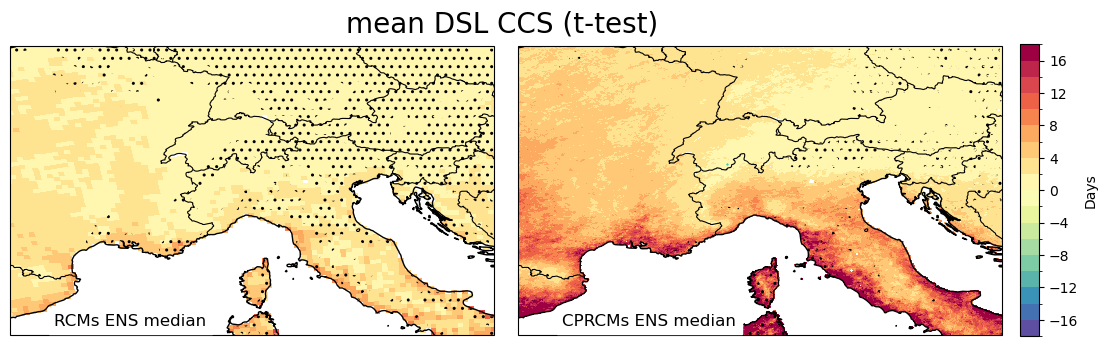

In [5]:
from matplotlib.gridspec import GridSpec

if D == 'ccs' : 
    cmap_std='viridis'
    # Create a colormap with your custom levels
    cmap_rcm = plt.get_cmap(colormap_ccs)
    cmap_cprcm = plt.get_cmap(colormap_ccs)
    cmap_std = plt.get_cmap(cmap_std,len(levels_std) - 1)  # Use len(levels) - 1 colors
    
    norm_rcm = mcolors.BoundaryNorm(levels, cmap_rcm.N, clip=False)
    norm_cprcm = mcolors.BoundaryNorm(levels, cmap_cprcm.N, clip=False)
    norm_std = mcolors.BoundaryNorm(levels_std, cmap_std.N, clip=False)
    
    fig, axes = plt.subplots(ncols=2,nrows=1, figsize=(12,7.2/2),
                             subplot_kw={'projection': ccrs.PlateCarree()})
    
    
    P1 = axes[0].pcolormesh(
            V_rcm.lon,
            V_rcm.lat,
            V_rcm.squeeze(),
            cmap=cmap_rcm,
            norm=norm_rcm,
            transform=ccrs.PlateCarree())    

    P2 = axes[1].pcolormesh(
            V_cprcm.lon,
            V_cprcm.lat,
            V_cprcm.squeeze(),
            cmap=cmap_cprcm,
            norm=norm_cprcm,
            transform=ccrs.PlateCarree())    
   

    axes[0].contourf(V_rcm.lon,V_rcm.lat,to_stipple_mask_rcm,hatches=['..'],alpha=0.0,transform=ccrs.PlateCarree()) 
    lon_grid = np.where(to_hatch_mask_rcm == 1,V_rcm.lon,np.nan)
    lat_grid = np.where(to_hatch_mask_rcm == 1,V_rcm.lat,np.nan)
    axes[0].plot(lon_grid, lat_grid, 'co', markersize=.5, transform=ccrs.PlateCarree())
    
    axes[1].contourf(V_cprcm.lon,V_cprcm.lat,to_stipple_mask_cprcm,hatches=['..'],alpha=0.0,transform=ccrs.PlateCarree()) 
    lon_grid = np.where(to_hatch_mask_cprcm == 1,V_cprcm.lon,np.nan)
    lat_grid = np.where(to_hatch_mask_cprcm == 1,V_cprcm.lat,np.nan)
    axes[1].plot(lon_grid, lat_grid, 'co', markersize=.5, transform=ccrs.PlateCarree())
    
  
    axes[0].coastlines(linewidth = 1)
    axes[0].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[0].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[0].set_facecolor('white')
    axes[0].text(2.45,40.8,'RCMs ENS median',fontsize=12,backgroundcolor='w',alpha=1)
    
    axes[1].coastlines(linewidth = 1)
    axes[1].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[1].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[1].set_facecolor('white')
    axes[1].text(2.45,40.8,'CPRCMs ENS median',fontsize=12,backgroundcolor='w',alpha=1)
      
    fig.subplots_adjust(left=.01,right=1, bottom=.05,top=.95,wspace=.05,hspace=.05)
    
    cb = fig.colorbar(P2, ax=(axes[0],axes[1]), orientation='vertical',
                      label=clabs[W],aspect=15,shrink=.90,pad=.015)#extend
    
    # Create a common title for the upper two panels
    fig.text(0.42, 0.94, f'{var_to_tit} CCS (t-test)', fontsize=20, ha='center')
  
    #plt.savefig(f'{fig_dir}/ensembles_{do_plot}_{var}.png')  
    plt.savefig(f'/users_home/cmcc/ls21622/tmp/ensembles_{do_plot}_{var}_ttest.png',dpi=300)  
    plt.show()    
    
    

### Plot CCS with t-test CDR adjustement 

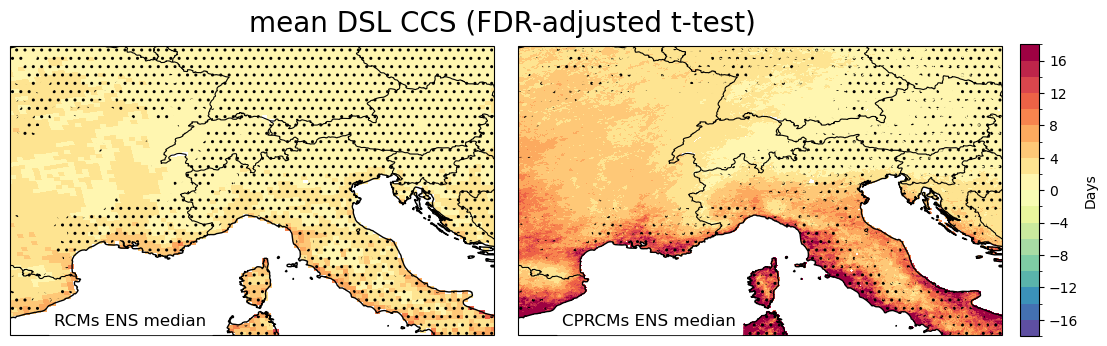

In [6]:
if D == 'ccs' : 
    cmap_std='viridis'
    # Create a colormap with your custom levels
    cmap_rcm = plt.get_cmap(colormap_ccs)
    cmap_cprcm = plt.get_cmap(colormap_ccs)
    cmap_std = plt.get_cmap(cmap_std,len(levels_std) - 1)  # Use len(levels) - 1 colors
    
    norm_rcm = mcolors.BoundaryNorm(levels, cmap_rcm.N, clip=False)
    norm_cprcm = mcolors.BoundaryNorm(levels, cmap_cprcm.N, clip=False)
    norm_std = mcolors.BoundaryNorm(levels_std, cmap_std.N, clip=False)
    
    fig, axes = plt.subplots(ncols=2,nrows=1, figsize=(12,7.2/2),
                             subplot_kw={'projection': ccrs.PlateCarree()})
    
       
    gs = GridSpec(2, 2, wspace=0.8, hspace=0.1)  # Adjust wspace and hspace as needed

    P1 = axes[0].pcolormesh(
            V_rcm.lon,
            V_rcm.lat,
            V_rcm.squeeze(),
            cmap=cmap_rcm,
            norm=norm_rcm,
            transform=ccrs.PlateCarree())    

    P2 = axes[1].pcolormesh(
            V_cprcm.lon,
            V_cprcm.lat,
            V_cprcm.squeeze(),
            cmap=cmap_cprcm,
            norm=norm_cprcm,
            transform=ccrs.PlateCarree())    
    
   
    
    axes[0].contourf(V_rcm.lon,V_rcm.lat,to_stipple_mask_fdr_rcm,hatches=['..'],alpha=0.0,transform=ccrs.PlateCarree()) 
    lon_grid = np.where(to_hatch_mask_fdr_rcm == 1,V_rcm.lon,np.nan)
    lat_grid = np.where(to_hatch_mask_fdr_rcm == 1,V_rcm.lat,np.nan)
    axes[0].plot(lon_grid, lat_grid, 'co', markersize=.5, transform=ccrs.PlateCarree())
    
    axes[1].contourf(V_cprcm.lon,V_cprcm.lat,to_stipple_mask_fdr_cprcm,hatches=['..'],alpha=0.0,transform=ccrs.PlateCarree()) 
    lon_grid = np.where(to_hatch_mask_fdr_cprcm == 1,V_cprcm.lon,np.nan)
    lat_grid = np.where(to_hatch_mask_fdr_cprcm == 1,V_cprcm.lat,np.nan)
    axes[1].plot(lon_grid, lat_grid, 'co', markersize=.5, transform=ccrs.PlateCarree())
    
  
    axes[0].coastlines(linewidth = 1)
    axes[0].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[0].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[0].set_facecolor('white')
    axes[0].text(2.45,40.8,'RCMs ENS median',fontsize=12,backgroundcolor='w',alpha=1)
    
    axes[1].coastlines(linewidth = 1)
    axes[1].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[1].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[1].set_facecolor('white')
    axes[1].text(2.45,40.8,'CPRCMs ENS median',fontsize=12,backgroundcolor='w',alpha=1)
    

    fig.subplots_adjust(left=.01,right=1, bottom=.05,top=.95,wspace=.05,hspace=.05)
    
    cb = fig.colorbar(P2, ax=(axes[0],axes[1]), orientation='vertical',
                      label=clabs[W],aspect=15,shrink=.90,pad=.015)#extend
    
    # Create a common title for the upper two panels
    fig.text(0.42, 0.94, f'{var_to_tit} CCS (FDR-adjusted t-test)', fontsize=20, ha='center')
  
    #plt.savefig(f'{fig_dir}/ensembles_{do_plot}_{var}.png')  
    plt.savefig(f'/users_home/cmcc/ls21622/tmp/ensembles_{do_plot}_{var}_ttest_fdr_adjusted.png',dpi=300)  
    plt.show()
    

### Plot CCS with monte carlo 

In [5]:
ds_montecarlo_RCM=xr.open_dataset(f'/data/cmcc/ls21622/gcm_driven_experiment_from_nird/scripts/python_2/hws/OUTPUTS/monte_carlo_test/monte_carlo_results_095_RCM_{variables[W]}.nc')
ds_montecarlo_CPRCM=xr.open_dataset(f'/data/cmcc/ls21622/gcm_driven_experiment_from_nird/scripts/python_2/hws/OUTPUTS/monte_carlo_test/monte_carlo_results_095_CPRCM_{variables[W]}.nc')
da_consensus_significant_RCM=ds_montecarlo_RCM.consensus_significant.where(~np.isnan(V_rcm.rename({'y':'lat','x':'lon'})))
da_consensus_significant_CPRCM=ds_montecarlo_CPRCM.consensus_significant.where(~np.isnan(V_cprcm.rename({'y':'lat','x':'lon'})))
da_consensus_significant_RCM = da_consensus_significant_RCM.where(da_consensus_significant_RCM == 0, np.nan)
da_consensus_significant_CPRCM = da_consensus_significant_CPRCM.where(da_consensus_significant_CPRCM == 0, np.nan)

NameError: name 'variables' is not defined

In [ ]:
if D == 'ccs' : 

    # Create a colormap with your custom levels
    cmap = plt.get_cmap(colormap_ccs[W], len(levels_ccs) - 1)
    cmap_std = plt.get_cmap(colormap_std,len(levels_std) - 1)
    # Create a BoundaryNorm for discrete levels
    norm = mcolors.BoundaryNorm(levels_ccs, cmap.N, clip=False)
    norm_std = mcolors.BoundaryNorm(levels_std, cmap_std.N, clip=False)
    
    fig, axes = plt.subplots(ncols=2,nrows=2, figsize=(12,7.2),
                             subplot_kw={'projection': ccrs.PlateCarree()})
        
    
    # Set the value for which you want to apply hatching
    hatch_value = 9999
    
    
    P1 = axes[0,0].pcolormesh(
            V_rcm.lon,
            V_rcm.lat,
            V_rcm.squeeze(),
            cmap=cmap,
            norm=norm,
            transform=ccrs.PlateCarree())    

    P2 = axes[0,1].pcolormesh(
            V_cprcm.lon,
            V_cprcm.lat,
            V_cprcm.squeeze(),
            cmap=cmap,
            norm=norm,
            transform=ccrs.PlateCarree())    
    
    P3 = axes[1,0].pcolormesh(
            V_rcm_std.lon,
            V_rcm_std.lat,
            V_rcm_std.squeeze(),
            cmap=cmap_std,
            norm=norm_std,
            transform=ccrs.PlateCarree())    

    P4 = axes[1,1].pcolormesh(
            V_cprcm_std.lon,
            V_cprcm_std.lat,
            V_cprcm_std.squeeze(),
            cmap=cmap_std,
            norm=norm_std,
            transform=ccrs.PlateCarree())    
   

    axes[0,0].contourf(            
        V_rcm.lon,
        V_rcm.lat,
        da_consensus_significant_RCM,
        hatches=['..'],
        alpha=0.0,
        transform=ccrs.PlateCarree())   
    
    
    axes[0,1].contourf(            
        V_cprcm.lon,
        V_cprcm.lat,
        da_consensus_significant_CPRCM,
        hatches=['..'],
        alpha=0.0,
        transform=ccrs.PlateCarree()) 
    
    
  
    axes[0,0].coastlines(linewidth = 1)
    axes[0,0].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[0,0].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[0,0].set_facecolor('white')
    axes[0,0].text(2.45,40.8,'RCMs ENS median',fontsize=12,backgroundcolor='w',alpha=1)
    
    axes[0,1].coastlines(linewidth = 1)
    axes[0,1].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[0,1].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[0,1].set_facecolor('white')
    axes[0,1].text(2.45,40.8,'CPRCMs ENS median',fontsize=12,backgroundcolor='w',alpha=1)
    

    axes[1,0].coastlines(linewidth = 1)
    axes[1,0].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[1,0].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[1,0].set_facecolor('white')
    axes[1,0].text(2.45,40.8,'RCMs ENS spread',fontsize=12,backgroundcolor='w',alpha=1)
    
    axes[1,1].coastlines(linewidth = 1)
    axes[1,1].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[1,1].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[1,1].set_facecolor('white')
    axes[1,1].text(2.45,40.8,'CPRCMs ENS spread',fontsize=12,backgroundcolor='w',alpha=1)
    
    fig.subplots_adjust(left=.01,right=1, bottom=.05,top=.95,wspace=.05,hspace=.05)
    
    cb = fig.colorbar(P2, ax=(axes[0,0],axes[0,1]), orientation='vertical',
                      label=clabs[W],aspect=15,shrink=.90,pad=.015)#extend
    cb = fig.colorbar(P4, ax=(axes[1,0],axes[1,1]), orientation='vertical',
                      label=clabs[W],aspect=15,shrink=.90,pad=.015)

    
    # Create a common title for the upper two panels
    fig.text(0.42, 0.95, f'{var_to_tit} CCS ', fontsize=20, ha='center')
  
    #plt.savefig(f'{fig_dir}/ensembles_{do_plot}_{var}.png')  
    plt.savefig(f'./ensembles_monte_carlo_{do_plot}_{var}_montecarlo.png',dpi=300)  
    plt.show()


### Plot CCS with monte carlo 

In [10]:
ds_montecarlo_RCM=xr.open_dataset(f'{root_dir}/scripts/python_2/hws/OUTPUTS/monte_carlo_test/monte_carlo_results_095_RCM_{var}.nc')
ds_montecarlo_CPRCM=xr.open_dataset(f'{root_dir}/scripts/python_2/hws/OUTPUTS/monte_carlo_test/monte_carlo_results_095_CPRCM_{var}.nc')
da_consensus_significant_RCM=ds_montecarlo_RCM.consensus_significant.where(~np.isnan(V_rcm.rename({'y':'lat','x':'lon'})))
da_consensus_significant_CPRCM=ds_montecarlo_CPRCM.consensus_significant.where(~np.isnan(V_cprcm.rename({'y':'lat','x':'lon'})))
da_consensus_significant_RCM = da_consensus_significant_RCM.where(da_consensus_significant_RCM == 0, np.nan)
da_consensus_significant_CPRCM = da_consensus_significant_CPRCM.where(da_consensus_significant_CPRCM == 0, np.nan)

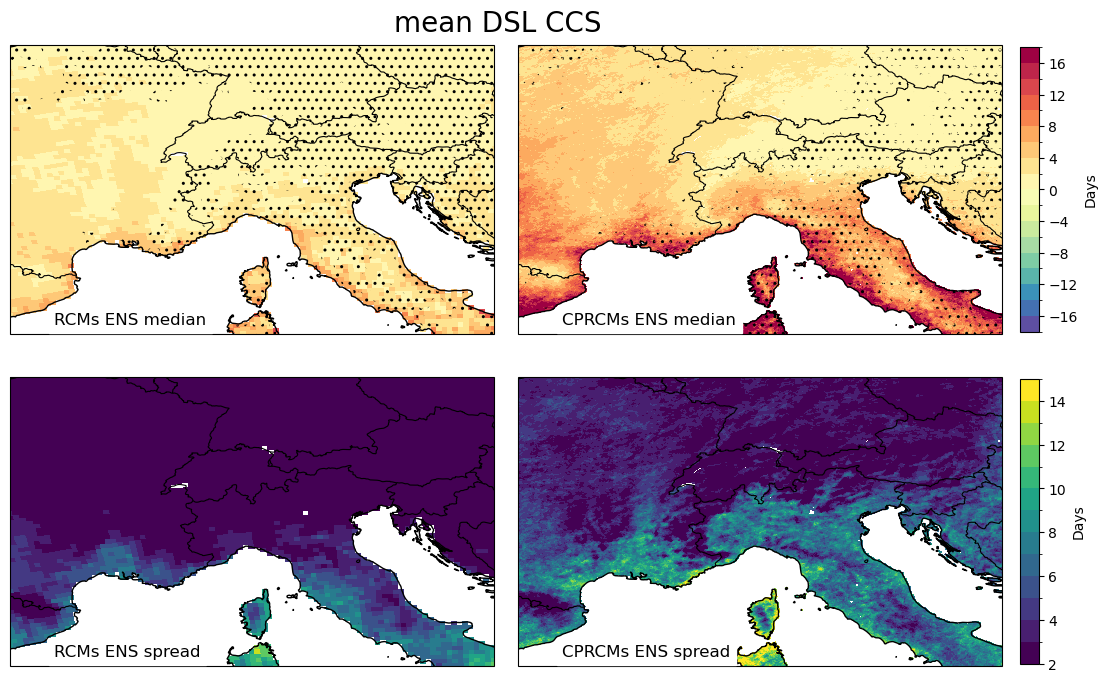

In [14]:
if D == 'ccs' : 

    cmap_std='viridis'
    # Create a colormap with your custom levels
    cmap_rcm = plt.get_cmap(colormap_ccs)
    cmap_cprcm = plt.get_cmap(colormap_ccs)
    cmap_std = plt.get_cmap(cmap_std,len(levels_std) - 1)  # Use len(levels) - 1 colors
    
    norm_rcm = mcolors.BoundaryNorm(levels, cmap_rcm.N, clip=False)
    norm_cprcm = mcolors.BoundaryNorm(levels, cmap_cprcm.N, clip=False)
    norm_std = mcolors.BoundaryNorm(levels_std, cmap_std.N, clip=False)
    
    fig, axes = plt.subplots(ncols=2,nrows=2, figsize=(12,7.2),
                             subplot_kw={'projection': ccrs.PlateCarree()})
    
    P1 = axes[0,0].pcolormesh(
            V_rcm.lon,
            V_rcm.lat,
            V_rcm.squeeze(),
            cmap=cmap_rcm,
            norm=norm_rcm,
            transform=ccrs.PlateCarree())    

    P2 = axes[0,1].pcolormesh(
            V_cprcm.lon,
            V_cprcm.lat,
            V_cprcm.squeeze(),
            cmap=cmap_cprcm,
            norm=norm_cprcm,
            transform=ccrs.PlateCarree())    
    
    P3 = axes[1,0].pcolormesh(
            V_rcm_std.lon,
            V_rcm_std.lat,
            V_rcm_std.squeeze(),
            cmap=cmap_std,
            norm=norm_std,
            transform=ccrs.PlateCarree())    

    P4 = axes[1,1].pcolormesh(
            V_cprcm_std.lon,
            V_cprcm_std.lat,
            V_cprcm_std.squeeze(),
            cmap=cmap_std,
            norm=norm_std,
            transform=ccrs.PlateCarree())    
   

    axes[0,0].contourf(            
        V_rcm.lon,
        V_rcm.lat,
        da_consensus_significant_RCM,
        hatches=['..'],
        alpha=0.0,
        transform=ccrs.PlateCarree())   
    
    
    axes[0,1].contourf(            
        V_cprcm.lon,
        V_cprcm.lat,
        da_consensus_significant_CPRCM,
        hatches=['..'],
        alpha=0.0,
        transform=ccrs.PlateCarree()) 
    
    
  
    axes[0,0].coastlines(linewidth = 1)
    axes[0,0].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[0,0].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[0,0].set_facecolor('white')
    axes[0,0].text(2.45,40.8,'RCMs ENS median',fontsize=12,backgroundcolor='w',alpha=1)
    
    axes[0,1].coastlines(linewidth = 1)
    axes[0,1].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[0,1].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[0,1].set_facecolor('white')
    axes[0,1].text(2.45,40.8,'CPRCMs ENS median',fontsize=12,backgroundcolor='w',alpha=1)
    

    axes[1,0].coastlines(linewidth = 1)
    axes[1,0].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[1,0].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[1,0].set_facecolor('white')
    axes[1,0].text(2.45,40.8,'RCMs ENS spread',fontsize=12,backgroundcolor='w',alpha=1)
    
    axes[1,1].coastlines(linewidth = 1)
    axes[1,1].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[1,1].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[1,1].set_facecolor('white')
    axes[1,1].text(2.45,40.8,'CPRCMs ENS spread',fontsize=12,backgroundcolor='w',alpha=1)
    
    fig.subplots_adjust(left=.01,right=1, bottom=.05,top=.95,wspace=.05,hspace=.05)
    
    cb = fig.colorbar(P2, ax=(axes[0,0],axes[0,1]), orientation='vertical',
                      label=clabs[W],aspect=15,shrink=.90,pad=.015)#extend
    cb = fig.colorbar(P4, ax=(axes[1,0],axes[1,1]), orientation='vertical',
                      label=clabs[W],aspect=15,shrink=.90,pad=.015)

    
    # Create a common title for the upper two panels
    fig.text(0.42, 0.95, f'{var_to_tit} CCS ', fontsize=20, ha='center')
  
    #plt.savefig(f'{fig_dir}/ensembles_{do_plot}_{var}.png')  
    plt.savefig(f'./ensembles_monte_carlo_{do_plot}_{var}_montecarlo.png',dpi=300)  
    plt.show()


In [15]:
f'./ensembles_monte_carlo_{do_plot}_{var}_montecarlo.png'

'./ensembles_monte_carlo_ccs_DSL_mean_montecarlo.png'